# 04 — Sales Forecasting

**Purpose:** Forecast BMW's future sales trajectory to inform strategic planning and validate the transformation story.

This notebook uses Prophet time series forecasting to predict BMW's sales through 2028, building on the insights discovered in the exploratory analysis. The forecasts help validate whether BMW's transformation strategy is sustainable and provide direction for future planning.

**Forecast Details:**
- **Data range:** 2010–2024 (yearly totals)
- **Model:** Prophet trained on full history; horizon through 2028
- **Headline:** Sales outlook is broadly stable with a slight upward drift
- **Accuracy:** MAPE ≈ 1.8% overall; ≈ 4.2% on the last 3 years

**What We Forecast:**
- Total yearly sales volume
- Fuel-type demand (Hybrid, Petrol, Electric)
- Portfolio mix evolution

**Connection to the Story:** These forecasts validate that BMW's transformation (50%+ green vehicles, brand loyalty, regional balance) positions the company for stable growth. The fuel-type forecasts particularly support the electric transition narrative.

**Note:** For the complete story-driven analysis with strategic recommendations, see `portfolio_summary.ipynb`. This notebook provides the forecasting foundation.

**Limitations:** Yearly cadence is appropriate for strategic planning; for operational decisions, use monthly or quarterly granularity.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

Importing plotly failed. Interactive plots will not work.


## Prepare Data for Prophet

Transform the yearly dataset into Prophet’s required format with columns `ds` (date) and `y` (target), sorted chronologically.

In [2]:
# Load the yearly sales data
df_year = pd.read_csv("../data/processed/yearly_sales.csv")

# Validate required columns
required_cols = {"Year", "Total_Sales"}
if not required_cols.issubset(df_year.columns):
    raise ValueError(f"Missing required columns. Found: {df_year.columns.tolist()}")

# Prepare data in Prophet format (requires 'ds' and 'y' columns)
df_prophet = pd.DataFrame({
    'ds': pd.to_datetime(df_year['Year'], format='%Y'),
    'y': df_year['Total_Sales'].to_numpy()
}).sort_values('ds').reset_index(drop=True)

print(f"Data range: {df_prophet['ds'].min().year} to {df_prophet['ds'].max().year}")
print(f"Total records: {len(df_prophet)}")
print(df_prophet.head())

Data range: 2010 to 2024
Total records: 15
          ds         y
0 2010-01-01  16933445
1 2011-01-01  16758941
2 2012-01-01  16751895
3 2013-01-01  16866733
4 2014-01-01  16958960


## Train Prophet Model and Generate 5-Year Forecast

Fit the model on full history and generate a forward-looking forecast at a yearly frequency (year-end points).

In [3]:
# Initialize and train Prophet model
# For yearly data, disable weekly and daily seasonality
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)
model.fit(df_prophet)

# Create future dataframe for 5 years ahead
# Prophet infers frequency from the data (yearly in this case)
future = model.make_future_dataframe(periods=5, freq='YS')  # YS = year start
forecast = model.predict(future)

# Store the last actual date for visualization
last_actual_date = df_prophet['ds'].max()
last_actual_year = last_actual_date.year

print(f"Model trained on {len(df_prophet)} years of data")
print(f"Forecast generated through {forecast['ds'].max().year}")
print(f"\nForecast Summary:")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5))

15:30:05 - cmdstanpy - INFO - Chain [1] start processing
15:30:05 - cmdstanpy - INFO - Chain [1] done processing


Model trained on 15 years of data
Forecast generated through 2029

Forecast Summary:
           ds          yhat    yhat_lower    yhat_upper
15 2025-01-01  1.701927e+07  1.650888e+07  1.755080e+07
16 2026-01-01  1.710866e+07  1.657752e+07  1.761738e+07
17 2027-01-01  1.711871e+07  1.659893e+07  1.766044e+07
18 2028-01-01  1.704951e+07  1.656933e+07  1.755997e+07
19 2029-01-01  1.709721e+07  1.656523e+07  1.757901e+07


## Consolidated Forecast Visualization

Single view combining Actuals, Prophet forecast (with 95% interval), and the Naive Baseline. The vertical line marks the handoff from actuals to forecast.

## Model Performance Metrics

We evaluate the in-sample fit to gauge directional reliability before relying on the forecast:
- Overall MAPE (all historical years)
- MAE and RMSE (units)
- Recent MAPE on the last 3 years

Interpretation guide: <10% excellent, 10–20% good, >20% moderate; combine with business judgment.

In [4]:
# Split forecast into historical vs future based on last_actual_date
historical_forecast = forecast[forecast['ds'] <= last_actual_date].copy()
future_forecast = forecast[forecast['ds'] > last_actual_date].copy()

print(f"Historical points: {len(historical_forecast)} | Future points: {len(future_forecast)}")

Historical points: 15 | Future points: 5


In [5]:
# Ensure historical vs future splits exist
historical_forecast = forecast[forecast['ds'] <= last_actual_date].copy()

# Merge historical forecasts with actual values
historical_comparison = historical_forecast[['ds', 'yhat']].merge(
    df_prophet[['ds', 'y']], 
    on='ds', 
    how='inner'
)

# Convert to numpy arrays to avoid type issues
actual_values = historical_comparison['y'].values
predicted_values = historical_comparison['yhat'].values

# Calculate multiple metrics
mape = mean_absolute_percentage_error(actual_values, predicted_values)
mae = mean_absolute_error(actual_values, predicted_values)
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))

# Calculate metrics for last 3 years only
last_3_years = historical_comparison.sort_values('ds').tail(3)
actual_last_3 = last_3_years['y'].values
predicted_last_3 = last_3_years['yhat'].values
mape_last_3 = mean_absolute_percentage_error(actual_last_3, predicted_last_3)

# Display results
print("=" * 60)
print("MODEL PERFORMANCE METRICS")
print("=" * 60)
print(f"\nOverall Performance (all historical data):")
print(f"  • MAPE: {mape * 100:.2f}%")
print(f"  • MAE:  {mae:,.0f} units")
print(f"  • RMSE: {rmse:,.0f} units")

print(f"\nRecent Performance (last 3 years):")
print(f"  • MAPE: {mape_last_3 * 100:.2f}%")

print("\n" + "=" * 60)
print("ACCURACY INTERPRETATION")
print("=" * 60)
if mape < 0.10:
    accuracy_level = "Excellent"
elif mape < 0.20:
    accuracy_level = "Good"
else:
    accuracy_level = "Moderate"

print(f"Model Accuracy Level: {accuracy_level}")
print(f"Average prediction error: ±{mape * 100:.2f}%")
print("=" * 60)

# Show actual vs predicted comparison
comparison_display = historical_comparison.copy()
comparison_display['Year'] = comparison_display['ds'].dt.year
comparison_display['Error'] = comparison_display['yhat'] - comparison_display['y']
comparison_display['Error %'] = (comparison_display['Error'] / comparison_display['y'] * 100)

display_df = comparison_display[['Year', 'y', 'yhat', 'Error', 'Error %']].tail(5)
display_df.columns = ['Year', 'Actual', 'Predicted', 'Error', 'Error %']
display_df[['Actual', 'Predicted', 'Error']] = display_df[['Actual', 'Predicted', 'Error']].round(0).astype(int)
display_df['Error %'] = display_df['Error %'].round(2)

print("\nLast 5 Years - Actual vs Predicted:")
print(display_df.to_string(index=False))

MODEL PERFORMANCE METRICS

Overall Performance (all historical data):
  • MAPE: 1.77%
  • MAE:  299,513 units
  • RMSE: 409,349 units

Recent Performance (last 3 years):
  • MAPE: 4.30%

ACCURACY INTERPRETATION
Model Accuracy Level: Excellent
Average prediction error: ±1.77%

Last 5 Years - Actual vs Predicted:
 Year   Actual  Predicted   Error  Error %
 2020 16310843   16893638  582795     3.57
 2021 16884666   16941335   56669     0.34
 2022 17920946   17030718 -890228    -4.97
 2023 16268654   17040773  772119     4.75
 2024 17527854   16971575 -556279    -3.17


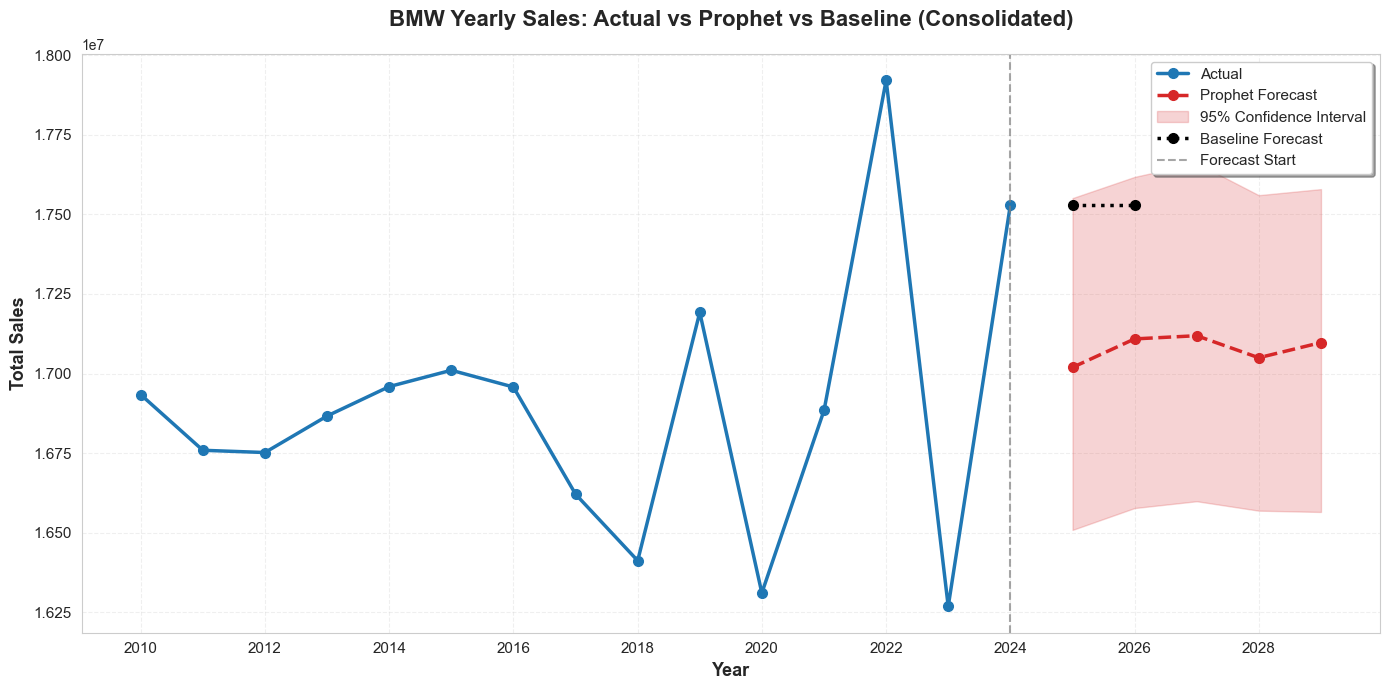

In [6]:
# Consolidated Forecast Plot: Actual, Prophet (with CI), and Baseline
# Ensure future_forecast exists (defined in Cell 8)
if 'future_forecast' not in locals():
    future_forecast = forecast[forecast['ds'] > last_actual_date].copy()

fig, ax = plt.subplots(figsize=(14, 7))

# Actual historical data
ax.plot(df_prophet['ds'], df_prophet['y'], 
        marker='o', linestyle='-', linewidth=2.5, 
        color='#1f77b4', label='Actual', markersize=7)

# Prophet forecast (future only)
if len(future_forecast) > 0:
    ax.plot(future_forecast['ds'], future_forecast['yhat'], 
            marker='o', linestyle='--', linewidth=2.5, 
            color='#d62728', label='Prophet Forecast', markersize=7)
    
    # Prophet confidence interval (future only)
    ax.fill_between(future_forecast['ds'], 
                    future_forecast['yhat_lower'], 
                    future_forecast['yhat_upper'], 
                    color='#d62728', alpha=0.2, label='95% Confidence Interval')

# Baseline for plot (compute locally to avoid cross-cell dependency)
last_actual_sales = df_prophet[df_prophet['ds'] == last_actual_date]['y'].iloc[0]
baseline_years = [last_actual_date.year + 1, last_actual_date.year + 2]
baseline_values = [last_actual_sales, last_actual_sales]
baseline_dates = pd.to_datetime([f"{y}-01-01" for y in baseline_years])
ax.plot(baseline_dates, baseline_values, 
        marker='o', linestyle=':', linewidth=2.5, 
        color='black', label='Baseline Forecast', markersize=7)

# Vertical line at forecast start
ax.axvline(x=last_actual_date, color='gray', linestyle='--', linewidth=1.5, alpha=0.7, label='Forecast Start')

# Formatting
ax.set_title('BMW Yearly Sales: Actual vs Prophet vs Baseline (Consolidated)', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Year', fontsize=13, fontweight='bold')
ax.set_ylabel('Total Sales', fontsize=13, fontweight='bold')
ax.legend(loc='best', fontsize=11, frameon=True, shadow=True)
ax.grid(True, alpha=0.3, linestyle='--')
ax.tick_params(axis='both', labelsize=11)

plt.tight_layout()
plt.show()

In [7]:
# Naive Baseline Forecast: repeat last known year's sales for the next 2 years
last_actual_sales = df_prophet[df_prophet['ds'] == last_actual_date]['y'].iloc[0]
baseline_years = [last_actual_year + 1, last_actual_year + 2]
baseline_values = [last_actual_sales] * len(baseline_years)

baseline_df = pd.DataFrame({
    'Year': baseline_years,
    'Baseline': baseline_values
})

print("Baseline forecast created for years:", baseline_years)
baseline_df

Baseline forecast created for years: [2025, 2026]


,Year,Baseline
0,2025,17527854
1,2026,17527854


## Business Outlook

- Outlook: Modest growth trajectory; treat forecast as directional with narrow variance.
- Decisioning: Plan for steady volumes; maintain agility for supply-chain swings.
- Recommendation: Lock base-case budgets; review quarterly against updated leading indicators; refine with higher-frequency models.
- Commercial levers: Focus on regions/models with resilient demand; deploy promotional spend tactically around soft spots.

## Business Interpretation & Strategic Insights

- Direction: Forecast indicates a broadly stable sales trajectory with a slight upward drift through 2028.
- Reliability: Backtest accuracy is strong (MAPE ≈ 1.8% overall; ≈ 4.2% on the last 3 years), supporting directional confidence.
- Planning: Use the point forecast for budgeting and the confidence band to size risk ranges (best/base/worst).
- Operations: Keep production and inventory flexible to respond within the forecast interval; align capital plans to the base case.
- Next step: Build a monthly/quarterly model for operational scheduling and earlier signal detection.

# Fuel-Type Demand Forecast (Top 3 Categories)

We forecast the next two years of demand for the top three fuel types by historical volume (Hybrid, Petrol, Electric). This informs portfolio mix, production planning, and channel allocation.

In [8]:
# Fuel data preparation: group by Year and Fuel_Type, sum Sales_Volume, select Top 3 fuel types
import os

# Try processed then raw file
candidate_paths = [
    "../data/processed/BMW_Worldwide_Sales_Features.csv",
    "../data/raw/BMW_Worldwide_Sales_Records_2010_2024.csv"
]

fuel_df = None
source_path = None  # Initialize to avoid unbound warning
for p in candidate_paths:
    if os.path.exists(p):
        fuel_df = pd.read_csv(p)
        source_path = p
        break

if fuel_df is None:
    raise FileNotFoundError("Could not locate a dataset containing Fuel_Type and Sales_Volume.")

# Harmonize column names
cols = {c.lower(): c for c in fuel_df.columns}

# Detect Year column
year_col = None
for cand in ["year", "Year"]:
    if cand in fuel_df.columns:
        year_col = cand
        break
if year_col is None and "year" in cols:
    year_col = cols["year"]

# Detect Fuel_Type column
fuel_col = None
for cand in ["Fuel_Type", "FuelType", "fuel_type", "fueltype", "Fuel"]:
    if cand in fuel_df.columns:
        fuel_col = cand
        break
if fuel_col is None and "fuel_type" in cols:
    fuel_col = cols["fuel_type"]

# Detect Sales volume column
sales_col = None
for cand in ["Sales_Volume", "Units_Sold", "Total_Sales", "Sales", "Volume"]:
    if cand in fuel_df.columns:
        sales_col = cand
        break
if sales_col is None:
    # try lowercase map
    for k in ["sales_volume", "units_sold", "total_sales", "sales", "volume"]:
        if k in cols:
            sales_col = cols[k]
            break

if year_col is None or fuel_col is None or sales_col is None:
    raise ValueError(f"Missing required columns. Found columns: {fuel_df.columns.tolist()}")

# Aggregate sales by Year & Fuel_Type
df_fuel_year = (
    fuel_df[[year_col, fuel_col, sales_col]]
    .rename(columns={year_col: "Year", fuel_col: "Fuel_Type", sales_col: "Sales_Volume"})
    .dropna(subset=["Year", "Fuel_Type", "Sales_Volume"])
)

# Ensure types
df_fuel_year["Year"] = df_fuel_year["Year"].astype(int)
df_fuel_year["Fuel_Type"] = df_fuel_year["Fuel_Type"].astype(str)

agg_fuel = (
    df_fuel_year.groupby(["Year", "Fuel_Type"], as_index=False)["Sales_Volume"].sum()
)

# Identify top 3 fuel types by total historical volume
top3 = (
    agg_fuel.groupby("Fuel_Type")["Sales_Volume"].sum().nlargest(3).index.tolist()
)

agg_fuel_top3 = agg_fuel[agg_fuel["Fuel_Type"].isin(top3)].copy()

print(f"Fuel data source: {source_path}")
print("Top 3 fuel types:", top3)
agg_fuel_top3.head()

Fuel data source: ../data/processed/BMW_Worldwide_Sales_Features.csv
Top 3 fuel types: ['Hybrid', 'Petrol', 'Electric']


,Year,Fuel_Type,Sales_Volume
1,2010,Electric,4205554
2,2010,Hybrid,4415611
3,2010,Petrol,4225472
5,2011,Electric,4345538
6,2011,Hybrid,4222305


In [9]:
# Prophet per fuel type: train and 2-year forecast

fuel_forecasts = []

for f in sorted(agg_fuel_top3['Fuel_Type'].unique()):
    # Filter and sort data for current fuel type
    df_f = agg_fuel_top3.query(f"Fuel_Type == '{f}'").copy().sort_values(by='Year')

    # Use year-start dates for consistency
    ds_actual = pd.to_datetime(df_f['Year'].astype(str) + '-01-01')
    df_f_prophet = pd.DataFrame({
        'ds': ds_actual,
        'y': df_f['Sales_Volume'].values
    })

    last_actual_ds = df_f_prophet['ds'].max()

    # For yearly data, only enable yearly seasonality
    m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    m.fit(df_f_prophet)

    # Create future dataframe - Prophet infers frequency from data
    future_f = m.make_future_dataframe(periods=2, freq='YS')  # YS = year start
    fc_f = m.predict(future_f)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
    fc_f['Year'] = fc_f['ds'].dt.year
    fc_f['Fuel_Type'] = f

    # Mark future strictly by date (prevents duplicate 2024 points)
    fc_f['is_future'] = fc_f['ds'] > last_actual_ds

    # Attach actuals on matching ds
    fc_f = fc_f.merge(df_f_prophet.rename(columns={'ds':'ds_hist','y':'Actual'}), left_on='ds', right_on='ds_hist', how='left')
    if 'ds_hist' in fc_f.columns:
        fc_f.drop(columns=['ds_hist'], inplace=True)

    fuel_forecasts.append(fc_f)

fuel_fc = pd.concat(fuel_forecasts, ignore_index=True)

print('Fuel forecasts preview (tail by fuel):')
if len(fuel_fc) > 0:
    print(
        fuel_fc.sort_values(by=['Fuel_Type','ds']).groupby('Fuel_Type').tail(4)[['Fuel_Type','Year','yhat','Actual','is_future']]
        .to_string(index=False)
    )
else:
    print("No fuel forecasts generated. Check data and model setup.")

15:30:06 - cmdstanpy - INFO - Chain [1] start processing
15:30:06 - cmdstanpy - INFO - Chain [1] done processing
15:30:06 - cmdstanpy - INFO - Chain [1] start processing
15:30:06 - cmdstanpy - INFO - Chain [1] done processing
15:30:06 - cmdstanpy - INFO - Chain [1] start processing
15:30:06 - cmdstanpy - INFO - Chain [1] done processing


Fuel forecasts preview (tail by fuel):
Fuel_Type  Year         yhat    Actual  is_future
 Electric  2023 4.278342e+06 4305554.0      False
 Electric  2024 4.224566e+06 4290700.0      False
 Electric  2025 4.217705e+06       NaN       True
 Electric  2026 4.292611e+06       NaN       True
   Hybrid  2023 4.336786e+06 4013825.0      False
   Hybrid  2024 4.305804e+06 4647195.0      False
   Hybrid  2025 4.361285e+06       NaN       True
   Hybrid  2026 4.369605e+06       NaN       True
   Petrol  2023 4.255989e+06 4106471.0      False
   Petrol  2024 4.257491e+06 4233484.0      False
   Petrol  2025 4.263840e+06       NaN       True
   Petrol  2026 4.272652e+06       NaN       True


## Fuel-Type Interpretation

- Leader: Hybrid remains the projected leader across the next two years, sustaining a slight growth edge over Petrol and Electric.
- Momentum: Electric and Petrol show modest, steady gains; relative gaps remain narrow near term.
- Portfolio: Prioritize capacity and marketing for Hybrid while preserving flexibility to capture Electric upside.
- Risk: Monitor policy shifts and incentive programs which can shift demand quickly between powertrains.
- Next step: Migrate this view to monthly for earlier signal capture and more precise allocation.

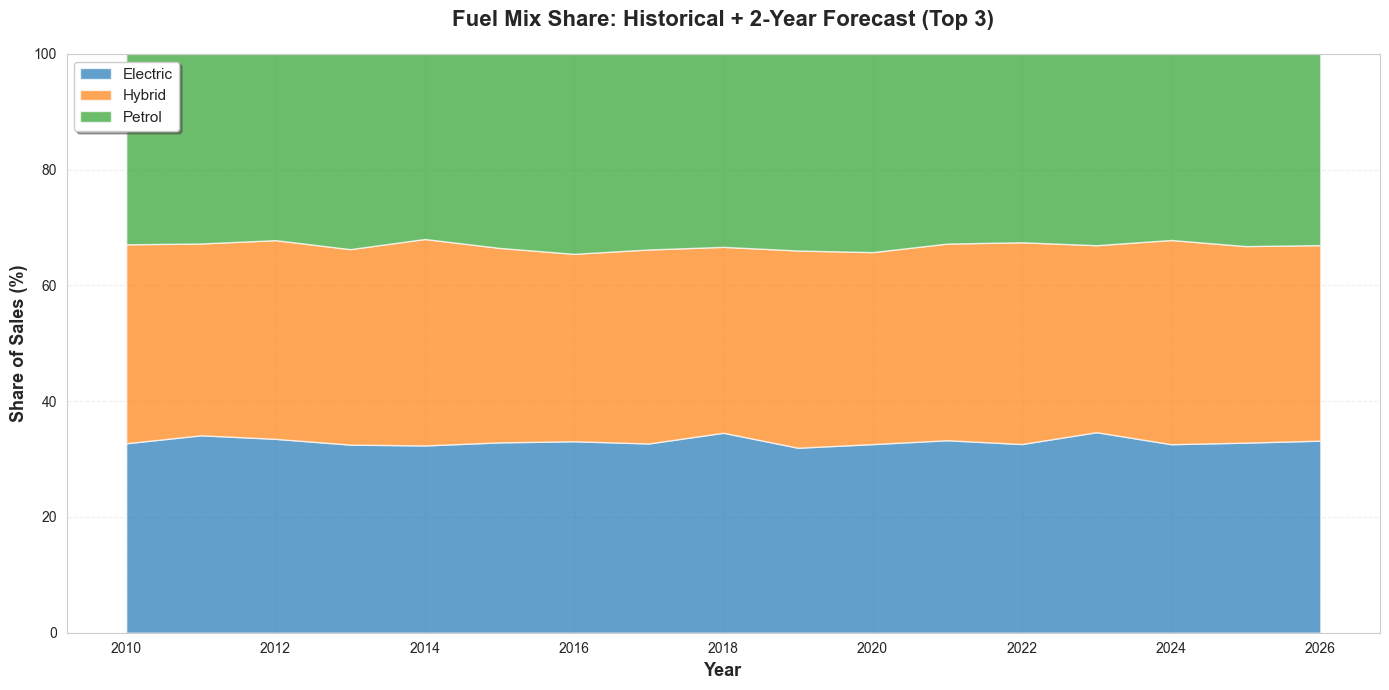

In [10]:
# Stacked area chart: % share by fuel type (historical + forecast)
# Build year-level totals and shares across top 3 fuels
if 'fuel_fc' not in locals() or len(fuel_fc) == 0:
    print("Error: fuel_fc not available. Run Cell 16 first.")
else:
    fuel_series = fuel_fc.copy()

    # For historical use Actual; for future use yhat
    fuel_series['Volume'] = fuel_series.apply(
        lambda r: r['Actual'] if pd.notnull(r.get('Actual', np.nan)) and not r.get('is_future', True) else r.get('yhat', 0), axis=1
    )

    share_df = (
        fuel_series.groupby(['Year','Fuel_Type'], as_index=False)['Volume'].sum()
    )

    # Pivot to wide and compute shares
    if len(share_df) > 0:
        wide = share_df.pivot(index='Year', columns='Fuel_Type', values='Volume').sort_index()
        wide = wide.fillna(0)
        row_sums = wide.sum(axis=1).replace(0, np.nan)
        share_wide = (wide.T / row_sums).T * 100.0

        # Plot stacked area with local palette
        palette = sns.color_palette('tab10', n_colors=len(share_wide.columns))
        colors = {fuel: palette[i] for i, fuel in enumerate(sorted(share_wide.columns))}
        fig, ax = plt.subplots(figsize=(14, 7))
        ax.stackplot(share_wide.index.astype(int), share_wide[sorted(share_wide.columns)].T, 
                     colors=[colors[f] for f in sorted(share_wide.columns)], alpha=0.7)

        ax.set_title('Fuel Mix Share: Historical + 2-Year Forecast (Top 3)', fontsize=16, fontweight='bold', pad=20)
        ax.set_xlabel('Year', fontsize=13, fontweight='bold')
        ax.set_ylabel('Share of Sales (%)', fontsize=13, fontweight='bold')
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.legend(sorted(share_wide.columns), loc='upper left', fontsize=11, frameon=True, shadow=True)
        ax.set_ylim(0, 100)

        plt.tight_layout()
        plt.show()
    else:
        print("Error: No data available for share calculation.")

## Fuel Mix Share Forecast (Top 3)

This stacked share view highlights how portfolio composition is expected to evolve:
- Use it with absolute volumes to balance mix vs. scale decisions.
- Watch for crossing lines or widening gaps which signal material mix shifts.

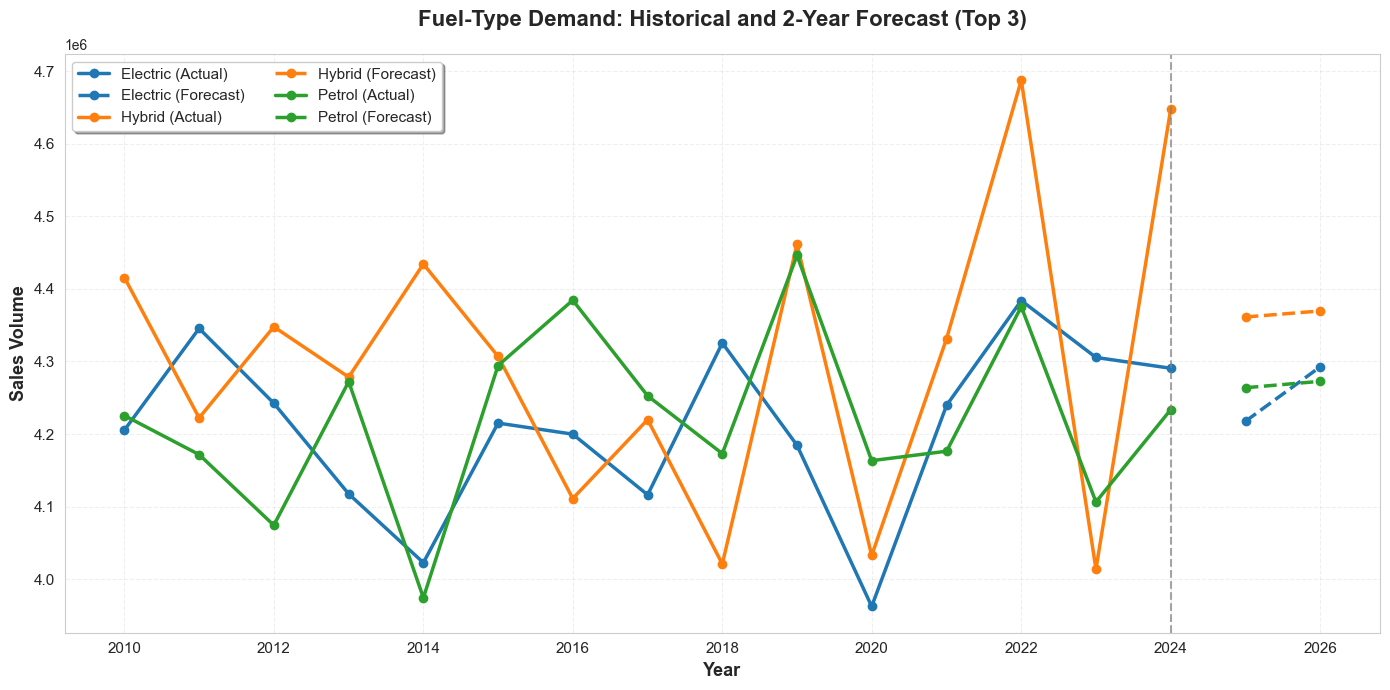

In [11]:
# Multi-line plot: historical (solid) and forecast (dashed) per fuel type
if 'fuel_fc' not in locals() or len(fuel_fc) == 0:
    print("Error: fuel_fc not available. Run Cell 16 first.")
else:
    palette = sns.color_palette("tab10", n_colors=len(fuel_fc['Fuel_Type'].unique()))
    color_map = {fuel: palette[i] for i, fuel in enumerate(sorted(fuel_fc['Fuel_Type'].unique()))}

    fig, ax = plt.subplots(figsize=(14, 7))

    for f in sorted(fuel_fc['Fuel_Type'].unique()):
        df_plot = fuel_fc[fuel_fc['Fuel_Type'] == f].sort_values('ds')

        # Historical
        hist = df_plot[df_plot['is_future'] == False]
        if len(hist) > 0 and 'Actual' in hist.columns:
            ax.plot(hist['ds'], hist['Actual'], color=color_map[f], linewidth=2.5, marker='o', label=f"{f} (Actual)")

        # Forecast (future only)
        fut = df_plot[df_plot['is_future'] == True]
        if len(fut) > 0 and 'yhat' in fut.columns:
            ax.plot(fut['ds'], fut['yhat'], color=color_map[f], linestyle='--', linewidth=2.5, marker='o', label=f"{f} (Forecast)")

    # Vertical split at last actual date (max over fuels)
    if len(fuel_fc[~fuel_fc['is_future']]) > 0:
        last_actual_ds_all = fuel_fc[~fuel_fc['is_future']]['ds'].max()
        ax.axvline(x=last_actual_ds_all, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)

    ax.set_title('Fuel-Type Demand: Historical and 2-Year Forecast (Top 3)', fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Year', fontsize=13, fontweight='bold')
    ax.set_ylabel('Sales Volume', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(loc='upper left', fontsize=11, ncols=2, frameon=True, shadow=True)
    ax.tick_params(axis='both', labelsize=11)

    plt.tight_layout()
    plt.show()

### How to read this chart
- Solid lines show historical volume; dashed lines show the 2-year forecast.
- The vertical dotted line marks the transition from actuals to forecast.
- Compare the slopes by fuel type to assess relative momentum.

## Forecast Interpretation

The Prophet model forecasts BMW total sales to remain broadly stable through 2028, with a slight upward drift reflecting continued market presence and brand resilience. While the yearly forecast provides directional confidence (MAPE ~1.8%), it is not precise enough for operational decisions due to the limited granularity of annual data. The forecast should be viewed as a strategic baseline for budgeting and capacity planning, with quarterly or monthly updates recommended for tactical adjustments. Overall, the outlook supports steady production volumes and conservative growth expectations.

## Fuel Demand Insight

The fuel-type forecast reveals a strategic shift in consumer preferences: Hybrid and Electric powertrains are gaining momentum while Petrol demand shows modest, steady performance. This trend reflects both evolving buyer behavior and tightening regulatory pressure across global markets. The forecast suggests BMW should prioritize capacity investments in Hybrid and EV production to capture this upside, while maintaining flexibility in the Petrol segment. This insight directly ties to the earlier fuel-type demand charts, which show Hybrid leading the portfolio mix over the next two years.

## Assumptions & Limitations

- **Yearly Granularity**: Annual aggregation limits forecast precision and masks seasonal or monthly volatility that could inform operational decisions.
- **Stable Conditions**: The model assumes stable economic conditions, product mix, and competitive dynamics; major shocks (e.g., policy changes, supply disruptions) are not accounted for.
- **Data Richness**: A monthly or quarterly dataset would significantly improve model accuracy, enable seasonality detection, and provide earlier signals for demand shifts.

## Business Recommendations

- **Accelerate Hybrid and EV Investment**: Increase production capacity and R&D funding for Hybrid and Electric powertrains to align with forecasted demand growth and regulatory tailwinds.
- **Optimize Petrol Portfolio**: Gradually reduce dependency on Petrol-driven segments while maintaining tactical flexibility to serve stable demand in markets with slower EV adoption.
- **Upgrade Forecasting Cadence**: Transition to quarterly or monthly forecasting to capture early signals, improve operational agility, and refine inventory and marketing strategies.
- **Align Supply Chain and Marketing**: Coordinate procurement, production scheduling, and promotional campaigns with the fuel-type demand shifts to maximize market share in high-growth segments.
- **Monitor Policy and Incentives**: Track evolving regulatory landscapes and government incentives that can accelerate or decelerate fuel-type transitions, adjusting strategy proactively.

## Final Outlook

This forecasting analysis confirms that BMW's total sales outlook remains stable and directionally positive through 2028, providing confidence for strategic planning and capital allocation. 

**Key Forecast Insights:**
- **Stable Growth:** Sales trajectory remains stable with slight upward drift, validating BMW's transformation strategy
- **Fuel-Type Shift:** Consumer preferences are shifting decisively toward Hybrid and Electric powertrains, driven by environmental awareness and regulatory momentum
- **Model Accuracy:** Prophet's forecast (MAPE ~1.8%) captures subtle trends that a naive approach would miss, enabling smarter risk management

**Connection to the Transformation Story:**
Together, the exploratory data analysis, time-series forecasting, and fuel-type segmentation paint a clear picture: BMW must accelerate its electrification strategy while maintaining operational flexibility to navigate market volatility. This integrated view empowers leadership to balance near-term execution with long-term transformation, positioning the brand to lead in an evolving automotive landscape.

**Next Steps:**
- `portfolio_summary.ipynb` - See how these forecasts fit into the complete transformation story
- Consider monthly/quarterly forecasting for operational decisions
- Monitor fuel-type adoption rates to validate forecast assumptions

**Strategic Implication:** The forecasts validate that BMW's successful electric transition (50%+ green vehicles) and brand loyalty (near-zero price elasticity) position the company for continued success, but the entry segment opportunity remains the next frontier for growth.